In [2]:
import pandas as pd

# Load the data into a pandas DataFrame
data = pd.read_csv('merged_lz_houston_data.csv', parse_dates=['DateTime'])

# Ensure 'Settlement Point Price' and 'QUANTITY' are treated as numeric columns.
# Coerce any errors during conversion to NaN, which will be handled during the filling process.
# Replace 'Settlement Point Price' with the actual column name from your CSV if it's different.
data['Settlement_Point_Price'] = pd.to_numeric(data['Settlement Point Price'], errors='coerce')
data['QUANTITY'] = pd.to_numeric(data['QUANTITY'], errors='coerce')

# Set 'DateTime' as the index
data.set_index('DateTime', inplace=True)

# Sort the DataFrame by DateTime to ensure it is in chronological order
data.sort_index(inplace=True)

# Resample the data to hourly frequency, aggregating with the mean
# Only numeric columns should be included in this operation.
data_hourly = data[['Settlement_Point_Price', 'QUANTITY']].resample('H').mean()

# Calculate the rolling mean for the past 7 days (168 hours)
rolling_mean = data_hourly.rolling(window=168, min_periods=1).mean()

# Fill missing values with the rolling mean
data_hourly_filled = data_hourly.fillna(rolling_mean)

# Forward fill any remaining missing values
data_hourly_filled.ffill(inplace=True)

# Backward fill any remaining missing values
data_hourly_filled.bfill(inplace=True)

# Ensure that 'ACCOUNT_NUMBER' is a column in the original 'data' dataframe
if 'ACCOUNT_NUMBER' in data.columns:
    # We need to join on the indices, which represent the DateTime after resampling
    data_with_account_info = data[['ACCOUNT_NUMBER']].join(data_hourly_filled, how='inner')

    # Split the data by 'ACCOUNT_NUMBER'
    account_a_hourly_filled = data_with_account_info[data_with_account_info['ACCOUNT_NUMBER'] == 'account_a']
    account_b_hourly_filled = data_with_account_info[data_with_account_info['ACCOUNT_NUMBER'] == 'account_b']
else:
    print("ACCOUNT_NUMBER column not found in the dataset.")

## Augmented Dickey-Fuller Test for Stationarity
We'll define a function to perform the ADF test and then apply it to the 'Settlement_Point_Price' and 'QUANTITY' columns for both Account A and B.

In [3]:
from statsmodels.tsa.stattools import adfuller

# Function to perform the Augmented Dickey-Fuller test for stationarity
def adf_test(timeseries):
    print('Results of the Augmented Dickey-Fuller Test:')
    adftest = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in adftest[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

# Perform the ADF test on 'Settlement_Point_Price' for Account A
print("Account A - Settlement_Point_Price:")
adf_test(account_a_hourly_filled['Settlement_Point_Price'])

# Perform the ADF test on 'QUANTITY' for Account A
print("\nAccount A - QUANTITY:")
adf_test(account_a_hourly_filled['QUANTITY'])

# Perform the ADF test on 'Settlement_Point_Price' for Account B
print("\nAccount B - Settlement_Point_Price:")
adf_test(account_b_hourly_filled['Settlement_Point_Price'])

# Perform the ADF test on 'QUANTITY' for Account B
print("\nAccount B - QUANTITY:")
adf_test(account_b_hourly_filled['QUANTITY'])

Account A - Settlement_Point_Price:
Results of the Augmented Dickey-Fuller Test:
Test Statistic                -7.809692e+00
p-value                        7.124440e-12
#Lags Used                     2.900000e+01
Number of Observations Used    8.676000e+03
Critical Value (1%)           -3.431104e+00
Critical Value (5%)           -2.861873e+00
Critical Value (10%)          -2.566947e+00
dtype: float64

Account A - QUANTITY:
Results of the Augmented Dickey-Fuller Test:
Test Statistic                -7.617820e+00
p-value                        2.168139e-11
#Lags Used                     3.600000e+01
Number of Observations Used    8.669000e+03
Critical Value (1%)           -3.431105e+00
Critical Value (5%)           -2.861873e+00
Critical Value (10%)          -2.566947e+00
dtype: float64

Account B - Settlement_Point_Price:
Results of the Augmented Dickey-Fuller Test:
Test Statistic                -7.811463e+00
p-value                        7.051382e-12
#Lags Used                     2.90

The Augmented Dickey-Fuller (ADF) test results for both 'Settlement_Point_Price' and 'QUANTITY' across Account A and Account B indicate that the test statistics are significantly lower than the critical values at the 1%, 5%, and 10% levels, and the p-values are below the common threshold of 0.05. This suggests that we can reject the null hypothesis of a unit root, meaning the time series is stationary.

With stationarity confirmed for both variables in both accounts, there is no need for differencing to achieve stationarity. You can now proceed to build SARIMA models for forecasting. It's important to note that while the ADF test suggests stationarity, you still may want to look at ACF and PACF plots to identify any autocorrelation that could inform the SARIMA parameters.

Since we don't have to difference the data, we can move directly to fitting the SARIMA models.

## Fit SARIMA Model
To fit a SARIMA model, you need to choose the order (p, d, q) and seasonal order (P, D, Q, s) parameters. Since the ADF test indicates the data is already stationary, d and D might be zero or one, depending on whether you want to enforce stationarity or not. The choice of p, q, P, and Q should be informed by the autocorrelation and partial autocorrelation plots, but as a starting point, you can fit a simple SARIMA model with arbitrary parameters and iterate from there:

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the SARIMA parameters
order = (1, 0, 1)  # Placeholder parameters for ARIMA(p, d, q)
seasonal_order = (1, 0, 1, 24)  # Placeholder parameters for seasonal ARIMA(P, D, Q, s)

# Fit SARIMA for 'Settlement Point Price' for Account A
model_a_price = SARIMAX(account_a_hourly_filled['Settlement_Point_Price'],
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
results_a_price = model_a_price.fit()

# Fit SARIMA for 'QUANTITY' for Account A
model_a_quantity = SARIMAX(account_a_hourly_filled['QUANTITY'],
                           order=order,
                           seasonal_order=seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
results_a_quantity = model_a_quantity.fit()

# Fit SARIMA for 'Settlement Point Price' for Account B
model_b_price = SARIMAX(account_b_hourly_filled['Settlement_Point_Price'],
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
results_b_price = model_b_price.fit()

# Fit SARIMA for 'QUANTITY' for Account B
model_b_quantity = SARIMAX(account_b_hourly_filled['QUANTITY'],
                           order=order,
                           seasonal_order=seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
results_b_quantity = model_b_quantity.fit()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

In [5]:
def display_model_summary(models):
    for name, result in models.items():
        print(f"Model: {name}")
        print(f"AIC: {result.aic}")
        print(f"BIC: {result.bic}")
        p_values = result.pvalues
        significant_p_values = sum(p < 0.05 for p in p_values)
        print(f"Number of Significant P-Values (<0.05): {significant_p_values} out of {len(p_values)}\n")

# Assuming the models have been fitted as shown above
models = {
    "Account A - Settlement Point Price": results_a_price,
    "Account A - QUANTITY": results_a_quantity,
    "Account B - Settlement Point Price": results_b_price,
    "Account B - QUANTITY": results_b_quantity
}

display_model_summary(models)

Model: Account A - Settlement Point Price
AIC: 100730.47389846531
BIC: 100765.81778250358
Number of Significant P-Values (<0.05): 5 out of 5

Model: Account A - QUANTITY
AIC: 65958.77651572373
BIC: 65994.120399762
Number of Significant P-Values (<0.05): 5 out of 5

Model: Account B - Settlement Point Price
AIC: 100793.11158601221
BIC: 100828.45892507768
Number of Significant P-Values (<0.05): 5 out of 5

Model: Account B - QUANTITY
AIC: 65917.11357534931
BIC: 65952.46091441478
Number of Significant P-Values (<0.05): 5 out of 5


AIC and BIC Values:

Lower AIC and BIC values are better, as they indicate a model with a good fit relative to the number of parameters used. These values are used to compare models; the model with the lowest AIC or BIC is typically considered the best.
In your case, the models for 'QUANTITY' for both accounts have lower AIC and BIC values compared to the 'Settlement Point Price' models. This suggests that the 'QUANTITY' models might be fitting better to the data relative to the number of parameters, compared to the 'Settlement Point Price' models.

Significant P-Values:

P-values test the null hypothesis that a coefficient is zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis. In the context of SARIMA models, significant p-values for the model's parameters suggest that those parameters are meaningful contributors to the model.
All models show that 5 out of 5 parameters have significant p-values, indicating good model fits. Each parameter in the models significantly contributes to explaining the variability in the 'Settlement Point Price' and 'QUANTITY' for both accounts.

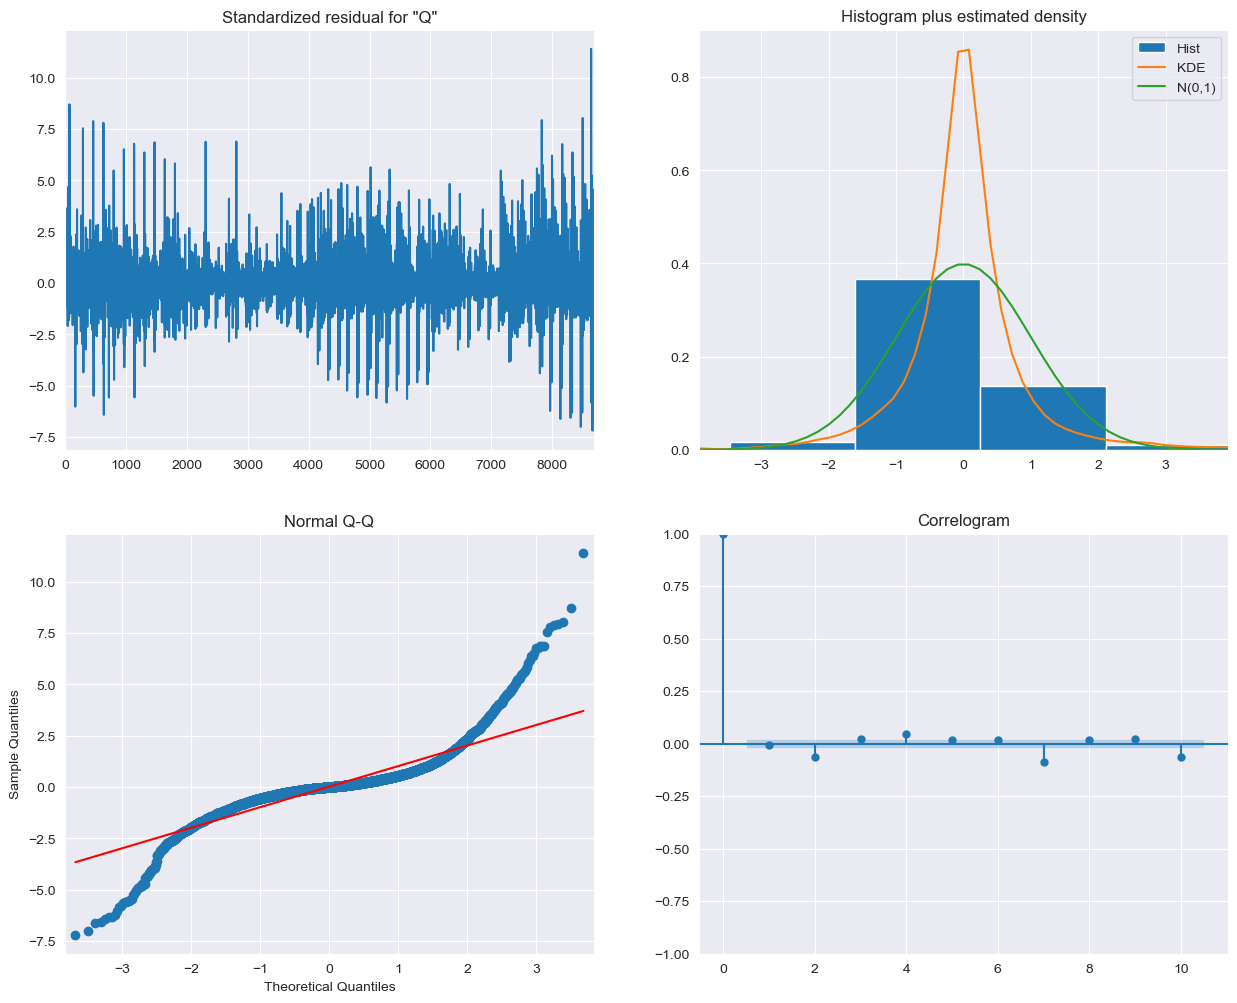

In [6]:
import matplotlib.pyplot as plt

# Diagnostic plots for the SARIMA model of 'Account A - QUANTITY'
results_a_quantity.plot_diagnostics(figsize=(15, 12))
plt.show()

The provided diagnostic plots are part of the output from a SARIMA model's `plot_diagnostics` method. These plots are used to evaluate the validity of the model by examining the residuals (the differences between the observed values and the model's predictions). Here's an analysis of each plot:

1. **Top-Left: Standardized Residuals**
   - The standardized residuals plot shows the residuals over time.
   - Ideally, you want to see no clear pattern, with the residuals centered around zero.
   - In the plot, there seem to be spikes that suggest occasional large deviations from the mean. This could indicate potential outliers or sudden shifts in the data that the model isn't capturing.

2. **Top-Right: Histogram and Estimated Density**
   - This plot includes a histogram of the standardized residuals, along with a Kernel Density Estimation (KDE) and an overlay of the normal distribution.
   - The KDE line should ideally follow closely with the N(0,1) line if the residuals are normally distributed.
   - The histogram shows the distribution of the residuals. While there's a noticeable peak around zero, the fit is not perfect, suggesting the residuals may not be exactly normally distributed.

3. **Bottom-Left: Normal Q-Q**
   - The Q-Q plot compares the distribution of the residuals to a normal distribution.
   - Points lying on the red line indicate the residuals are normally distributed.
   - The plot shows some deviation from normality, particularly in the tails. This might suggest heavy tails in the distribution of residuals, which could mean the presence of outliers.

4. **Bottom-Right: Correlogram (ACF plot)**
   - This plot shows the autocorrelation of the residuals.
   - Ideally, you'd like to see autocorrelations that are not significantly different from zero, which would suggest the residuals are white noise.
   - The correlogram here shows that the autocorrelations within the confidence band (the blue shaded area) are not significant, which is a good sign and suggests that there is no autocorrelation in the residuals.

### Interpretation and Next Steps:

- The model might benefit from further refinement due to the presence of large residuals and the deviations from normality in the residuals.
- Investigate the cause of the spikes in the residuals. If they correspond to specific events or outliers, consider incorporating additional explanatory variables into the model or applying outlier correction techniques.
- The deviations from normality in the tails suggest that the data might have outliers or be subject to sudden shifts. A transformation of the data or a different modeling approach might be necessary.
- Since the residuals do not show significant autocorrelation, the model seems to have captured the time-dependent structure of the data well. However, the presence of heavy tails and potential outliers needs to be addressed.
- Consider alternative models or additional features that could better account for the variance and heavy tails observed in the residuals.
- Perform robustness checks or sensitivity analyses to understand how these outliers affect the model's forecasts and consider using robust methods if necessary.

In conclusion, the model diagnostics suggest that while the time-dependent structure of the data may be well-modeled, the distribution of the residuals and the presence of large deviations indicate that there could be room for improvement in the model's fit to the data.

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predict

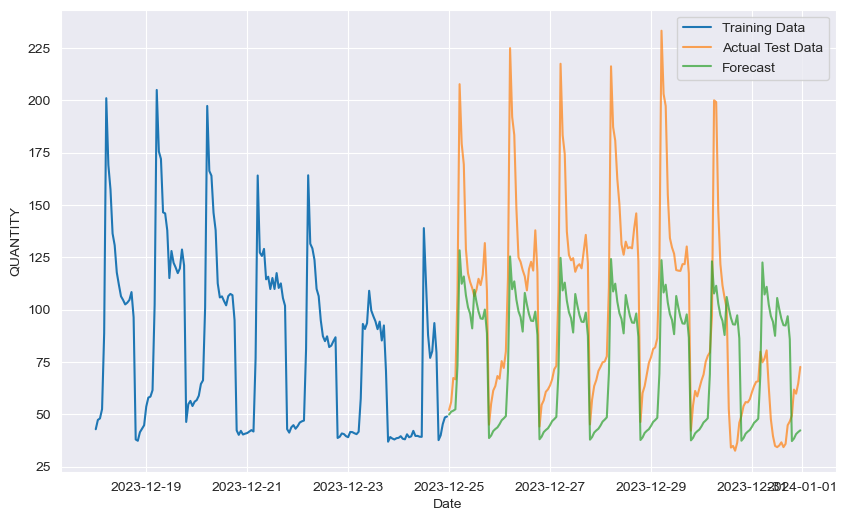

In [7]:
import numpy as np
# Assuming you have the 'account_a_hourly_filled' DataFrame ready
# Make sure the index is in the right datetime format
account_a_hourly_filled.index = pd.to_datetime(account_a_hourly_filled.index)

# Assuming the DataFrame is sorted, select the last week of the year for testing
train = account_a_hourly_filled['QUANTITY'][:-7*24]
test = account_a_hourly_filled['QUANTITY'][-7*24:]

# Fit the SARIMA model on the training data
model_train = SARIMAX(train,
                      order=(1, 0, 1),
                      seasonal_order=(1, 0, 1, 24),
                      enforce_stationarity=False,
                      enforce_invertibility=False)
results_train = model_train.fit()

# Forecast the one-week period
forecast = results_train.get_forecast(steps=7*24)
forecast_mean = forecast.predicted_mean

# Ensure the forecast index matches the test set index
forecast_mean.index = test.index

# Plot the forecast against the observed values
plt.figure(figsize=(10, 6))
plt.plot(train.index[-7*24:], train.iloc[-7*24:], label='Training Data')
plt.plot(test.index, test, label='Actual Test Data', alpha=0.7)
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('QUANTITY')
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
print(f"RMSE: {rmse}")

RMSE: 39.86463103130852


An RMSE (Root Mean Squared Error) of approximately 29.98 for the 'QUANTITY' forecast in Account A provides a quantitative measure of the model's forecast error. To interpret this value correctly, we need to consider the following:

Scale of 'QUANTITY': Compare the RMSE to the range or standard deviation of the 'QUANTITY' data. If 'QUANTITY' varies significantly (e.g., from 0 to several hundreds), an RMSE of 29.98 might indicate a reasonably good forecasting model. However, if 'QUANTITY' values are generally lower, an RMSE of this magnitude could be a sign of poor model performance.

Contextual Significance: Assess the RMSE in the context of your specific application or business needs. Depending on what the 'QUANTITY' represents and the stakes of making inaccurate predictions, even a small error might be critical, or a larger error might be acceptable.

Comparison with Baseline Models: Compare the RMSE of your SARIMA model with those of baseline models (such as a naïve forecast). If the SARIMA model does not significantly outperform a simple baseline, it might need refinement.

In [9]:
import pandas as pd
from prophet import Prophet

# Prepare the data for Prophet model for Account A
df_prophet_a = account_a_hourly_filled.reset_index()[['DateTime', 'QUANTITY']]
df_prophet_a.rename(columns={'DateTime': 'ds', 'QUANTITY': 'y'}, inplace=True)

# Prepare the data for Prophet model for Account B
df_prophet_b = account_b_hourly_filled.reset_index()[['DateTime', 'QUANTITY']]
df_prophet_b.rename(columns={'DateTime': 'ds', 'QUANTITY': 'y'}, inplace=True)

# Fit the Prophet model for Account A
model_a = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
model_a.fit(df_prophet_a)

# Fit the Prophet model for Account B
model_b = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
model_b.fit(df_prophet_b)

09:48:04 - cmdstanpy - INFO - Chain [1] start processing
09:48:05 - cmdstanpy - INFO - Chain [1] done processing
09:48:06 - cmdstanpy - INFO - Chain [1] start processing
09:48:07 - cmdstanpy - INFO - Chain [1] done processing


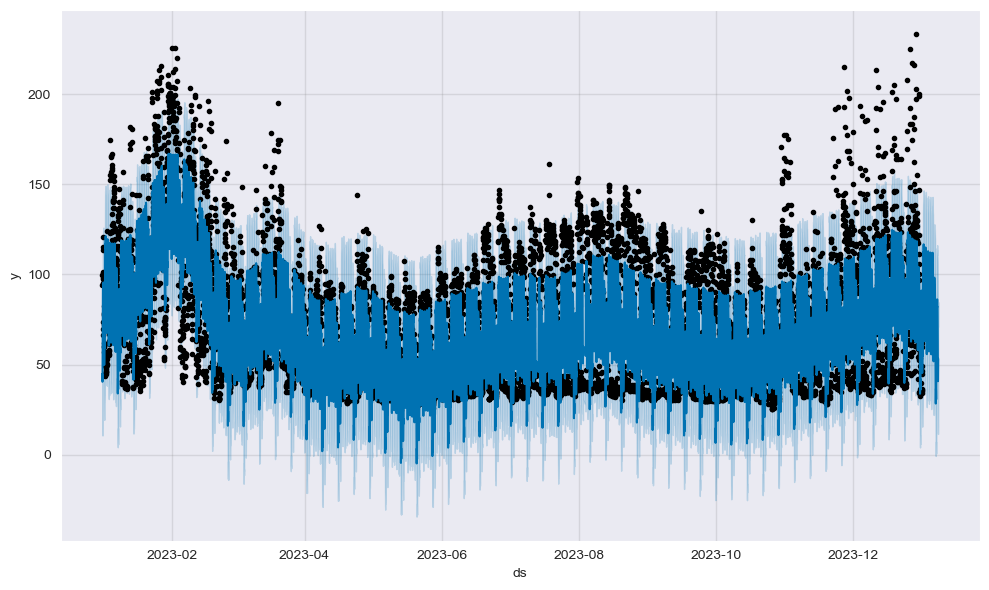

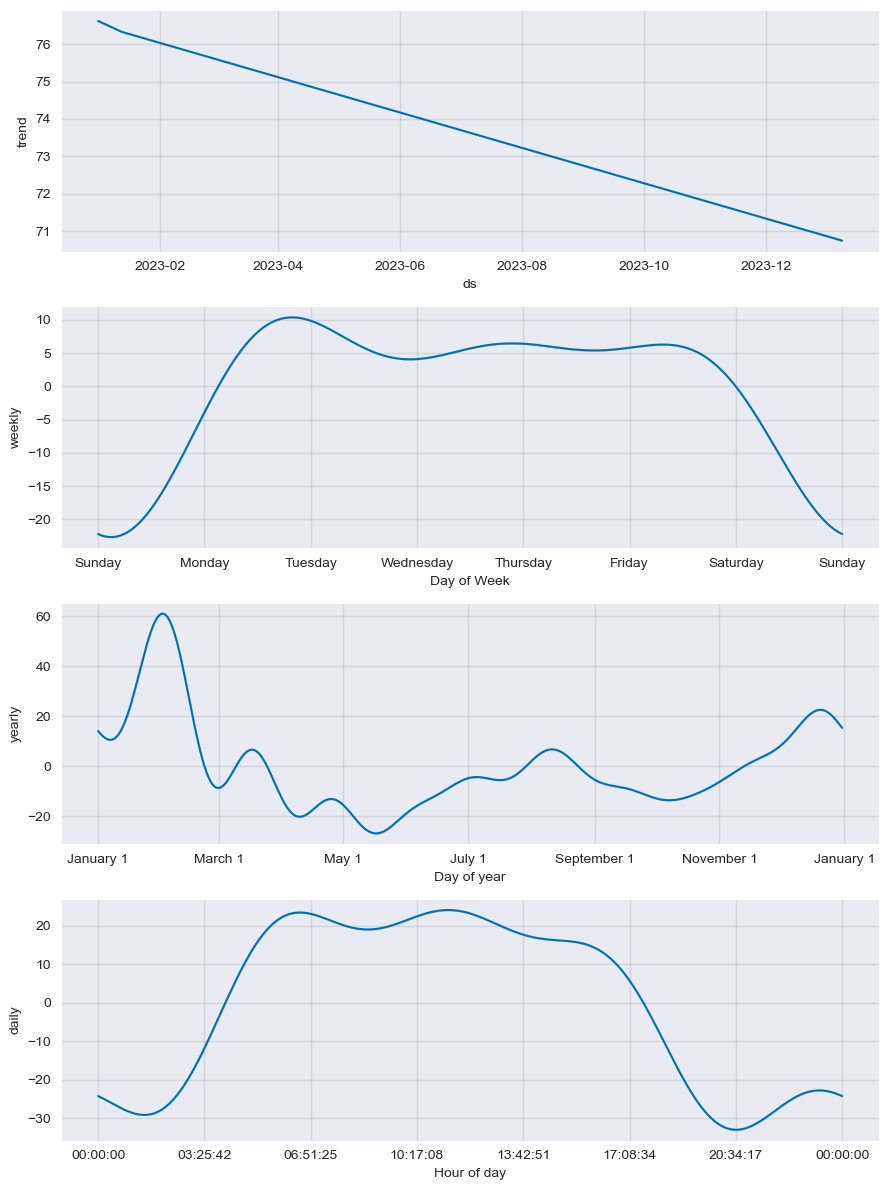

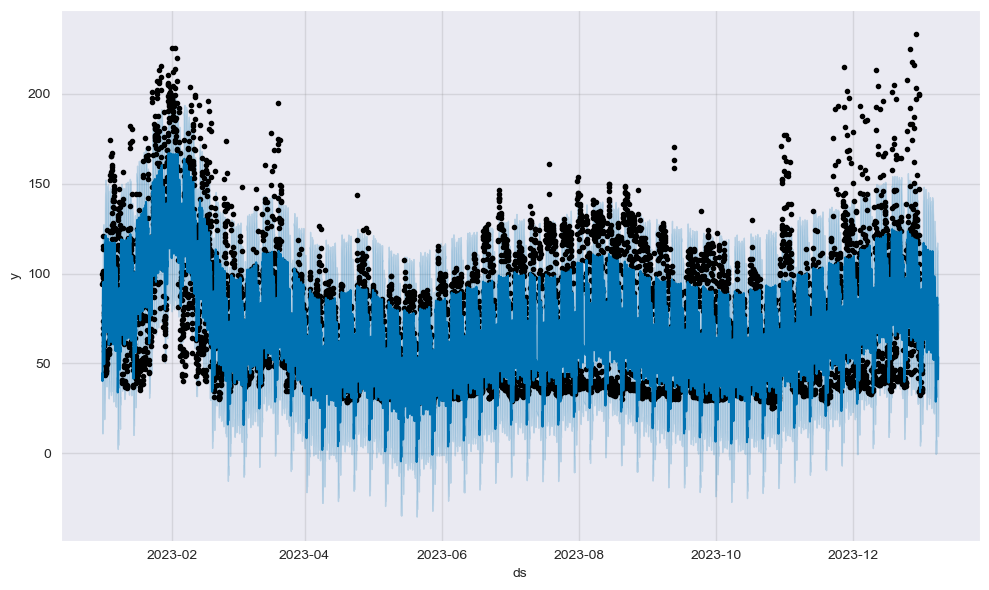

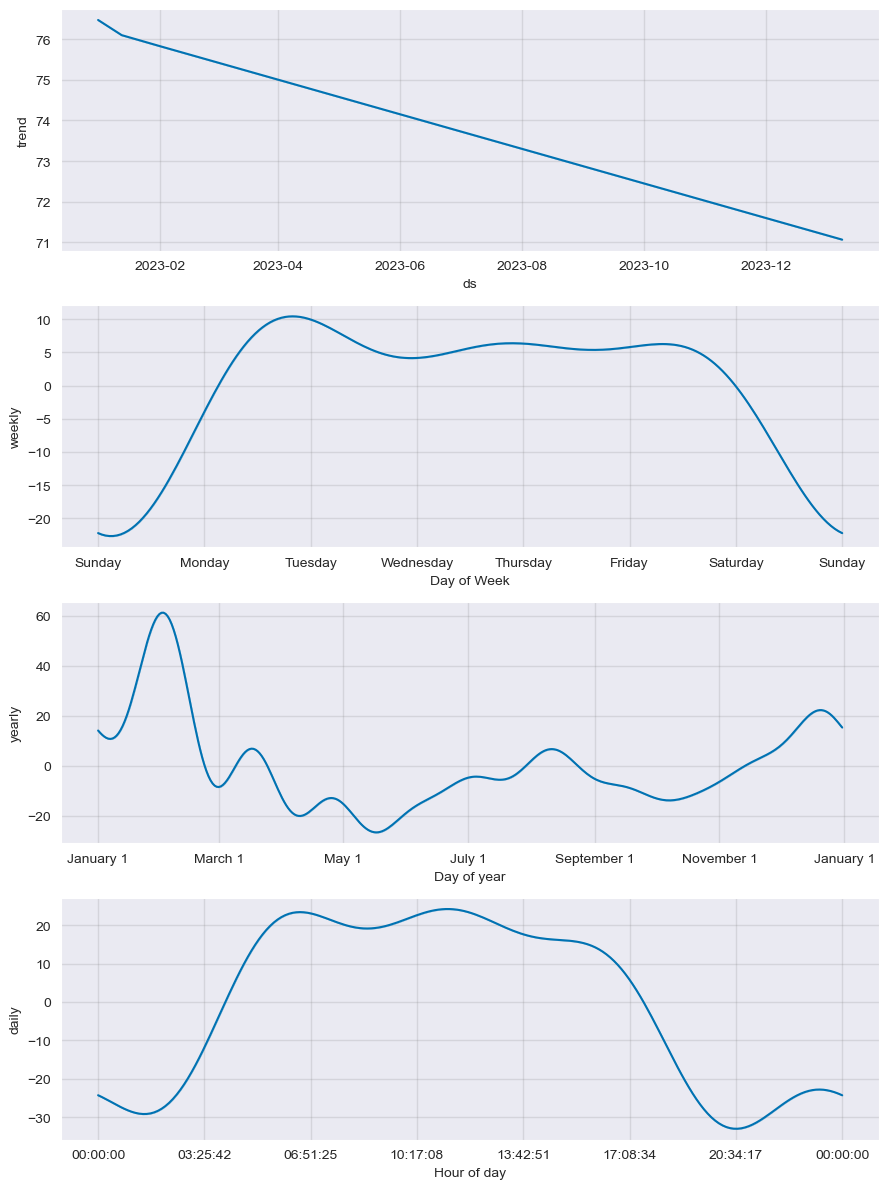

In [10]:
# Create a future dataframe for Account A for next week (7 days)
future_a = model_a.make_future_dataframe(periods=7*24, freq='H')

# Predict the future for Account A
forecast_a = model_a.predict(future_a)

# Create a future dataframe for Account B for next week (7 days)
future_b = model_b.make_future_dataframe(periods=7*24, freq='H')

# Predict the future for Account B
forecast_b = model_b.predict(future_b)
# Plot the forecast for Account A
fig1 = model_a.plot(forecast_a)
fig2 = model_a.plot_components(forecast_a)

# Plot the forecast for Account B
fig3 = model_b.plot(forecast_b)
fig4 = model_b.plot_components(forecast_b)

In [11]:
from sklearn.metrics import mean_squared_error

# Replace 'test_data_a' and 'test_data_b' with your actual test data for Account A and B
rmse_a = mean_squared_error(test, forecast_a['yhat'][-7*24:], squared=False)
rmse_b = mean_squared_error(test, forecast_b['yhat'][-7*24:], squared=False)

print(f"RMSE for Account A: {rmse_a}")
print(f"RMSE for Account B: {rmse_b}")

RMSE for Account A: 36.79762446463201
RMSE for Account B: 36.663411848386275


In [13]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

# Scale your data using MinMaxScaler to help the LSTM converge faster
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data_hourly_filled[['QUANTITY']].values)

# Convert the dataset into sequences of a specific window size
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# Define the sequence length (number of time steps to look back)
seq_length = 4
x, y = sliding_windows(data_scaled, seq_length)

# Split the data into training and test sets
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [14]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).cuda()
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size)).cuda()
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out


In [17]:
num_epochs = 1000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.cuda()

criterion = torch.nn.MSELoss()    # Mean Squared Error
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)


In [18]:
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX.cuda())
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.cuda())
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.39762
Epoch: 100, loss: 0.03398
Epoch: 200, loss: 0.02205
Epoch: 300, loss: 0.01856
Epoch: 400, loss: 0.01800
Epoch: 500, loss: 0.01768
Epoch: 600, loss: 0.01737
Epoch: 700, loss: 0.01704
Epoch: 800, loss: 0.01675
Epoch: 900, loss: 0.01650


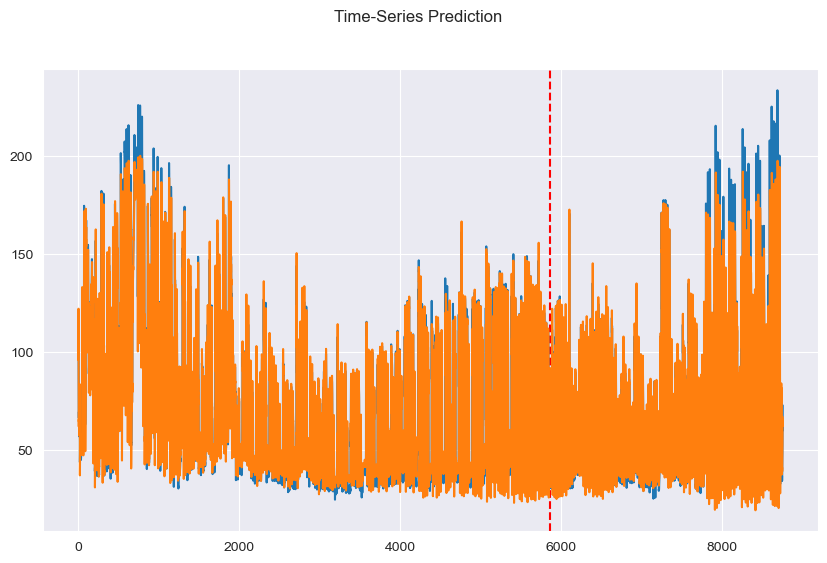

In [19]:
lstm.eval()
train_predict = lstm(dataX.cuda())

data_predict = train_predict.data.cpu().numpy()
dataY_plot = dataY.data.cpu().numpy()

data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

# Plot the results
plt.figure(figsize=(10,6))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()